In [1]:
# --- Colab Setup ---
# If using Google Drive for data, uncomment the next two lines:
# from google.colab import drive
# drive.mount('/content/drive')

# Install dependencies (add or remove as needed)
!pip install numpy pandas matplotlib scikit-learn lpips deepinv

%matplotlib inline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.0/752.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 59.9 MB/s eta 0:00:00


In [2]:
# Block 0: imports, metrics, denoisers, reproducibility
import os

import math, numpy as np, torch, torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from skimage import data, restoration, filters, morphology
from PIL import Image
import random
import lpips
from scipy.ndimage import distance_transform_edt

os.makedirs("results_lab2", exist_ok=True)

# --- Reproducibility ---
SEED = 12345  # EDIT if desired
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Optional LPIPS
USE_LPIPS = True
try:
    lpips_fn = lpips.LPIPS(net='alex').eval().to(device) if USE_LPIPS else None
except Exception:
    lpips_fn = None
    print("LPIPS disabled or missing. pip install lpips to enable.")


def load_rgb01():
    img = Image.fromarray(data.astronaut())
    x = T.ToTensor()(img).unsqueeze(0)  # [1,3,H,W] in [0,1]
    return x.to(device)


def psnr(ref, out, eps=1e-12):
    mse = F.mse_loss(out, ref)
    return float(10.0 * torch.log10(1.0 / (mse + eps)))


def lpips_score(ref, out):
    if lpips_fn is None: return None
    with torch.no_grad():
        return float(lpips_fn(ref.clamp(0, 1) * 2 - 1, out.clamp(0, 1) * 2 - 1).mean().item())


# Denoisers (numpy HWC -> numpy HWC), then back to torch
def to_numpy_img(x):
    return x.detach().cpu().permute(0, 2, 3, 1).numpy()[0]  # HWC in [0,1]


def to_torch_img(arr, like):
    t = torch.from_numpy(arr).permute(2, 0, 1).unsqueeze(0).to(like.device, dtype=like.dtype)
    return t.clamp(0, 1)



DRUNET = None


def get_drunet(device):
    global DRUNET
    if DRUNET is not None:
        return DRUNET
    try:
        import deepinv as dinv
        from deepinv.models import DRUNet
        DRUNET = DRUNet(pretrained="download", device=device).eval()  # auto-download weights
        return DRUNET
    except Exception as e:
        print("DRUNet unavailable. Install with: pip install deepinv")
        print("Error:", e)
        return None


def denoise_image(img_np, kind="bilateral", strength=0.1, median_size=3):
    """
        kind: "median" | "bilateral" | "nlm" | "drunet"
        strength:
            - bilateral: sigma_color ( 0.020.2)
            - nlm: h ( 0.050.2)
            - drunet: noise sigma in [0,1] (e.g., 0.05 for 5% of 0-1 range)
    """

    if kind == "median":
        selem = morphology.disk(max(1, int(median_size)))
        out = np.zeros_like(img_np)
        for c in range(img_np.shape[2]):
            out[:, :, c] = filters.median(img_np[:, :, c], footprint=selem)
        return out
    elif kind == "bilateral":
        return restoration.denoise_bilateral(img_np, sigma_color=strength, sigma_spatial=3, channel_axis=-1)
    elif kind == "nlm":
        patch_kw = dict(patch_size=3, patch_distance=5, channel_axis=-1, fast_mode=True)
        return restoration.denoise_nl_means(img_np, h=strength, **patch_kw)

    elif kind == "drunet":
        # DRUNet expects torch tensor in NCHW, [0,1], and a noise level sigma in [0,1]
        x = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).float()  # 1xCxHxW
        x = x.to(device)
        model = get_drunet(device)
        if model is None:
            return img_np  # fallback no-op if not installed
        with torch.no_grad():
            # DRUNet signature: y = model(x, sigma) ; sigma \in [0,1]
            y = model(x, float(strength)).clamp(0, 1)
        return y.squeeze(0).permute(1, 2, 0).cpu().numpy()
    else:
        return img_np  # no-op

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 197MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


In [3]:
# Dictionary to store observed images + masks
x_clean = load_rgb01().to(device)  # [B,C,H,W]
B, C, H, W = x_clean.shape
N = H * W

# Levels of masking (rho = p%) and noise (sigma)
rho_levels = [20.0, 50.0, 80.0]       # % of dropped pixels
sigma_levels = [0.0, 0.01, 0.05]

observed_images = {}   # keys: (p, sigma), values: torch tensor [B,C,H,W]
observed_masks  = {}   # keys: (p, sigma), values: torch tensor [H,W]

fig, axes = plt.subplots(len(rho_levels), len(sigma_levels)+2, figsize=(15, 10))

for i, p in enumerate(rho_levels):
    # --- Construct mask (same across all sigma for this row) ---
    num_drop = int(max(0.0, min(100.0, p)) * 0.01 * N)
    idx = np.arange(N)
    np.random.shuffle(idx)
    drop = idx[:num_drop]
    M = np.ones((N,), dtype=np.float32)
    M[drop] = 0.0
    M = torch.from_numpy(M.reshape(H, W)).to(device)
    M3 = M.unsqueeze(0).unsqueeze(0).repeat(1, C, 1, 1)

    for j, noise_sigma in enumerate(sigma_levels):
        # --- Apply noise + mask ---
        y = x_clean.clone()
        if noise_sigma > 0:
            y = (y + noise_sigma * torch.randn_like(y)).clamp(0, 1)
        y = y * M3

        # --- Store for later ---
        observed_images[(p, noise_sigma)] = y.clone()
        observed_masks[(p, noise_sigma)]  = M.clone()   # save the mask too

        # --- Compute metrics ---
        kept_pct = 100.0 * (1.0 - num_drop / max(1, N))
        psnr_val = psnr(x_clean, y)
        lpips_val = lpips_score(x_clean, y)
        print(f"p={p:.1f}% drop, σ={noise_sigma:.3f} → kept {kept_pct:.1f}% | "
              f"PSNR={psnr_val:.2f}, LPIPS={lpips_val:.3f}")

        # --- Plot ---
        if j == 0:  # show clean + mask in first two cols
            axes[i, 0].imshow(x_clean[0].permute(1, 2, 0).cpu().clip(0, 1))
            axes[i, 0].set_title("Clean")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(M.cpu(), vmin=0, vmax=1, cmap='gray')
            axes[i, 1].set_title(f"Mask p={p:.0f}%")
            axes[i, 1].axis('off')

        axes[i, j+2].imshow(y[0].permute(1, 2, 0).cpu().clip(0, 1))
        axes[i, j+2].set_title(f"σ={noise_sigma:.2f}")
        axes[i, j+2].axis('off')

plt.tight_layout()
plt.savefig("results_lab2/lab2b_inpaint_grid.png", dpi=200)
plt.show()
plt.close()

# Now observed_images and observed_masks each have 9 entries
print("Stored observed images:", list(observed_images.keys()))
print("Stored observed masks:", list(observed_masks.keys()))


Output hidden; open in https://colab.research.google.com to view.

PnP-ADMM (inpaint) PSNR: 26.865528106689453 LPIPS: 0.10151619464159012


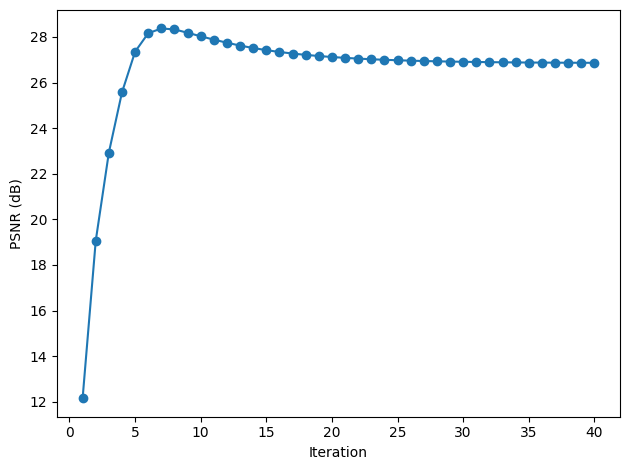

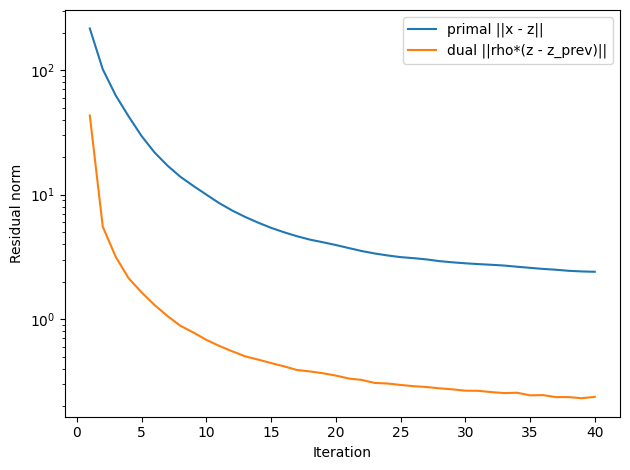

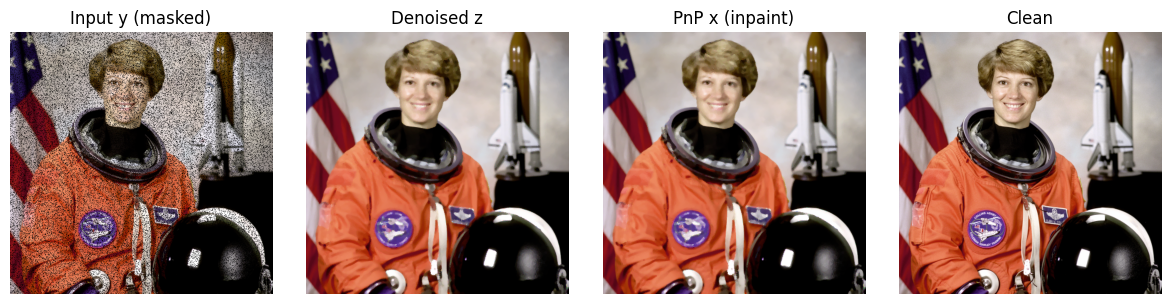

In [7]:
# Block 2: PnP-ADMM with data term 0.5*|| M * (x - y) ||^2 (elementwise *)
rho = 0.2  # EDIT if desired (ADMM penalty)
iters = 40  # EDIT if desired (iterations)
kind = "median"  # EDIT: "median" | "bilateral" | "nlm" | "drunet"
strength = 0.1  # EDIT: denoiser strength
median_size = 3  # EDIT: for median only
# init
y = observed_images[(20.0, 0.00)]  # [B,C,H,W]
M = observed_masks[(20.0, 0.00)]  # [H,W]
M3 = M.unsqueeze(0).unsqueeze(0).repeat(1, C, 1, 1)  # [B,C,H,W]
x = y.clone()
z = y.clone()
u = torch.zeros_like(y)
psnr_hist = []
r_norm, s_norm = [], []  # ADMM residuals
for t in range(1, iters + 1):
    # x-update: (M + rho I) x = M * y + rho * (z - u) --> element-wise
    rhs = y + rho * (z - u)
    denom = M3 + rho  # broadcast over channels
    x = (rhs / denom).clamp(0, 1)
    # z-update: PnP denoiser on x + u
    x_plus_u = (x + u).clamp(0, 1)
    img_np = to_numpy_img(x_plus_u)
    den_np = denoise_image(img_np, kind=kind, strength=strength, median_size=median_size)
    z_new = to_torch_img(den_np, x_plus_u)
    # residuals
    r = (x - z_new).reshape(-1)
    s = (rho * (z_new - z)).reshape(-1)
    r_norm.append(float(torch.norm(r).item()))
    s_norm.append(float(torch.norm(s).item()))
    z = z_new
    u = u + x - z
    # metric
    psnr_hist.append(psnr(x_clean, x))

print("PnP-ADMM (inpaint) PSNR:", psnr(x_clean, x), "LPIPS:", lpips_score(x_clean, x))

# Convergence plots
plt.figure()
plt.plot(range(1, len(psnr_hist) + 1), psnr_hist, marker='o')
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")
plt.tight_layout()
plt.savefig("results_lab2/lab2b_inpaint_psnr_curve.png", dpi=200)
plt.show()
plt.close()

plt.figure()
plt.plot(range(1, len(r_norm) + 1), r_norm, label="primal ||x - z||")
plt.plot(range(1, len(s_norm) + 1), s_norm, label="dual ||rho*(z - z_prev)||")
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Residual norm")
plt.legend()
plt.tight_layout()
plt.savefig("results_lab2/lab2b_inpaint_residuals.png", dpi=200)
plt.show()
plt.close()

plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.imshow(y[0].permute(1, 2, 0).cpu().clip(0, 1))
plt.axis('off')
plt.title("Input y (masked)")
plt.subplot(1, 4, 2)
plt.imshow(z[0].permute(1, 2, 0).cpu().clip(0, 1))
plt.axis('off')
plt.title("Denoised z")
plt.subplot(1, 4, 3)
plt.imshow(x[0].permute(1, 2, 0).cpu().clip(0, 1))
plt.axis('off')
plt.title("PnP x (inpaint)")
plt.subplot(1, 4, 4)
plt.imshow(x_clean[0].permute(1, 2, 0).cpu().clip(0, 1))
plt.axis('off')
plt.title("Clean")
plt.tight_layout()
plt.savefig("results_lab2/lab2b_inpaint_pnp.png", dpi=200)
plt.show()
plt.close()

In [ ]:
denoisers = ["median" ,"bilateral" ,"nlm" , "drunet"]
all_results = {}   # will hold results per (p, sigma)
strength = 0.3


for (p, sigma), y_obs in observed_images.items():   # loop over saved images
    print(f"\n=== Processing case: p={p:.1f}% drop, σ={sigma:.3f} ===")
    case_results = {}

    # Ground-truth
    x_gt = x_clean.clone()   # [B,C,H,W]

    # Use the stored mask instead of recomputing
    M = observed_masks[(p, sigma)]        # shape [H,W]
    M3_img = M.unsqueeze(0).unsqueeze(0).repeat(1, C, 1, 1)  # [B,C,H,W]

    for kind in denoisers:
        # Re-initialize variables
        x = y_obs.clone()
        z = y_obs.clone()
        u = torch.zeros_like(y_obs)
        psnr_hist = []
        r_norm, s_norm = [], []

        for t in range(1, iters + 1):
            # x-update
            rhs = y_obs + rho * (z - u)
            denom = M3_img + rho
            x = (rhs / denom).clamp(0, 1)

            # z-update (denoising step)
            x_plus_u = (x + u).clamp(0, 1)
            img_np = to_numpy_img(x_plus_u)
            den_np = denoise_image(img_np, kind=kind,
                                   strength=strength, median_size=median_size)
            z_new = to_torch_img(den_np, x_plus_u)

            # residuals
            r = (x - z_new).reshape(-1)
            s = (rho * (z_new - z)).reshape(-1)
            r_norm.append(float(torch.norm(r).item()))
            s_norm.append(float(torch.norm(s).item()))

            z = z_new
            u = u + x - z

            # PSNR metric
            psnr_hist.append(psnr(x_gt, x))

        final_psnr = psnr(x_gt, x)
        final_lpips = lpips_score(x_gt, x)
        case_results[kind] = {
            "psnr_hist": psnr_hist,
            "r_norm": r_norm,
            "s_norm": s_norm,
            "final_psnr": final_psnr,
            "final_lpips": final_lpips,
            "x": x.clone(),
            "z": z.clone()
        }
        print(f"{kind} → PSNR={final_psnr:.2f}, LPIPS={final_lpips:.4f}")

    # Save per-(p, sigma) results
    all_results[(p, sigma)] = case_results

# === Plot results per case ===
for (p, sigma), case_results in all_results.items():
    print(f"\n=== Results for p={p:.1f}%, σ={sigma:.3f} ===")

    # PSNR curves
    plt.figure()
    for kind in denoisers:
        plt.plot(case_results[kind]["psnr_hist"], label=kind)
    plt.xlabel("Iteration")
    plt.ylabel("PSNR (dB)")
    plt.legend()
    plt.title(f"PnP-ADMM Inpainting: PSNR convergence (p={p:.0f}%, σ={sigma:.2f})")
    plt.tight_layout()
    plt.show()

    # Reconstructions
    plt.figure(figsize=(12, 3))
    for i, kind in enumerate(denoisers):
        plt.subplot(1, len(denoisers), i + 1)
        plt.imshow(case_results[kind]["x"][0].permute(1, 2, 0).cpu().clip(0, 1))
        plt.axis("off")
        psnr_val = case_results[kind]["final_psnr"]
        plt.title(f"{kind}\nPSNR={psnr_val:.2f} dB")
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Baseline B: nearest-neighbor fill
def nn_fill(img_np, mask_np):
    """
        Fill missing pixels (mask=0) with the value of the nearest known pixel (mask=1).
        Nearest neighbour in Euclidean distance.
        img_np: HxWxC, floats in [0,1] or uint8
        mask_np: HxW, 1=known, 0=missing
    """
    out = img_np.copy()
    # Compute distance transform: returns indices of nearest known pixel
    dist, (idx_y, idx_x) = distance_transform_edt(1 - mask_np, return_indices=True)

    # Fill missing pixels for each channel from nearest known pixel
    for c in range(img_np.shape[2]):
        out[..., c] = img_np[idx_y, idx_x, c]
    return out


# BLOCK 3: Compare denoisers with baselines for each case
for (p, sigma), case_results in all_results.items():
    print(f"\n=== Comparing methods for p={p:.1f}%, σ={sigma:.3f} ===")

    # Get observed image and its mask
    y = observed_images[(p, sigma)]
    mask_np = observed_masks[(p, sigma)].cpu().numpy()   # ✅ use stored mask

    # Baseline A: zero-fill (just the observed y)
    rec_a = y.clone()

    # Baseline B: nearest-neighbor fill
    img_np = to_numpy_img(y)
    fill_np = nn_fill(img_np, mask_np)
    rec_b = to_torch_img(fill_np, y)

    # Calculate baseline metrics
    psnr_a = psnr(x_clean, rec_a)
    lpips_a = lpips_score(x_clean, rec_a)
    psnr_b = psnr(x_clean, rec_b)
    lpips_b = lpips_score(x_clean, rec_b)

    print(f"Zero-fill:  PSNR={psnr_a:.2f}, LPIPS={lpips_a:.4f}")
    print(f"NN-fill:    PSNR={psnr_b:.2f}, LPIPS={lpips_b:.4f}")

    # Print PnP denoiser results
    for kind in denoisers:
        pnp_psnr = case_results[kind]["final_psnr"]
        pnp_lpips = case_results[kind]["final_lpips"]
        print(f"{kind:10s}: PSNR={pnp_psnr:.2f}, LPIPS={pnp_lpips:.4f}")

    # Visual comparison
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # First row: ground truth, observed, baselines
    axes[0, 0].imshow(x_clean[0].permute(1, 2, 0).cpu().clip(0, 1))
    axes[0, 0].set_title("Ground Truth"); axes[0, 0].axis('off')

    axes[0, 1].imshow(y[0].permute(1, 2, 0).cpu().clip(0, 1))
    axes[0, 1].set_title(f"Observed\n(p={p:.0f}%, σ={sigma:.2f})"); axes[0, 1].axis('off')

    axes[0, 2].imshow(rec_a[0].permute(1, 2, 0).cpu().clip(0, 1))
    axes[0, 2].set_title(f"Zero-fill\nPSNR={psnr_a:.2f}"); axes[0, 2].axis('off')

    axes[0, 3].imshow(rec_b[0].permute(1, 2, 0).cpu().clip(0, 1))
    axes[0, 3].set_title(f"NN-fill\nPSNR={psnr_b:.2f}"); axes[0, 3].axis('off')

    # Second row: PnP denoisers
    for j, kind in enumerate(denoisers):
        pnp_psnr = case_results[kind]["final_psnr"]
        axes[1, j].imshow(case_results[kind]["x"][0].permute(1, 2, 0).cpu().clip(0, 1))
        axes[1, j].set_title(f"{kind}\nPSNR={pnp_psnr:.2f}")
        axes[1, j].axis('off')

    plt.tight_layout()
    plt.savefig(f"results_lab2/lab2b_comparison_p{p:.0f}_sigma{sigma:.2f}.png",
                dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()


# === Summary table across all cases ===
print("\n" + "="*80)
print("SUMMARY TABLE: PSNR (dB) across all cases")
print("="*80)
print(f"{'Case':<15} {'Zero-fill':<10} {'NN-fill':<10} ", end="")
for kind in denoisers:
    print(f"{kind:<10}", end="")
print()

for (p, sigma), case_results in all_results.items():
    case_str = f"p={p:.0f}%,σ={sigma:.2f}"

    # Baselines
    y = observed_images[(p, sigma)]
    mask_np = observed_masks[(p, sigma)].cpu().numpy()   # ✅ use stored mask
    rec_a = y.clone()
    img_np = to_numpy_img(y)
    fill_np = nn_fill(img_np, mask_np)
    rec_b = to_torch_img(fill_np, y)

    psnr_a = psnr(x_clean, rec_a)
    psnr_b = psnr(x_clean, rec_b)

    print(f"{case_str:<15} {psnr_a:<10.2f} {psnr_b:<10.2f} ", end="")
    for kind in denoisers:
        pnp_psnr = case_results[kind]["final_psnr"]
        print(f"{pnp_psnr:<10.2f}", end="")
    print()

print("="*80)


Output hidden; open in https://colab.research.google.com to view.